In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import hashlib
import shutil
import glob
import time
import re
import os

from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
   

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
pragaurd = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/genome_obfus_meta.msg')

/opt/conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
pragaurd.head()

,permission_len,dex_opcode_len,dex_method_len,dex_api_len,dex_apil2_len,native_opcode_len,native_functions_len,md5,obfustype,family,dataset
0003a4cb962a89fb372b73106a999024,5,20093,3120,3120,2184,1268,86,0003a4cb962a89fb372b73106a999024,TRIVIAL+STRING_ENCRYPTION+REFLECTION+CLASS_ENC...,DroidKungFu2,Genome
0011c0672e7069b78007f04056c1c31f,18,36707,7269,7269,5071,0,0,0011c0672e7069b78007f04056c1c31f,TRIVIAL+STRING_ENCRYPT_APK,KMin,Genome
0015397ee26b7cfb78f20287b74b08c1,11,31301,4894,4894,3436,1268,86,0015397ee26b7cfb78f20287b74b08c1,CLASS_ENCRYPTION_APK,DroidKungFu3,Genome
0019abca6cbe1d0753f19fb7de070b9e,16,32146,6941,6941,3977,0,0,0019abca6cbe1d0753f19fb7de070b9e,TRIVIAL+STRING_ENCRYPT_APK,BaseBridge,Genome
001c97d9341f1ffddffbff77c5ee7a58,9,54918,9954,9954,3339,48404,1,001c97d9341f1ffddffbff77c5ee7a58,TRIVIAL+STRING_ENCRYPT_APK,BeanBot,Genome


In [109]:
vshare_df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/vshare_meta.msg')

/opt/conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [112]:
vshare_df = vshare_df.loc[vshare_df.sha256.isin(androzoo_df.sha256)]

In [ ]:
vshare_df = vshare_df.sha256

In [113]:
len(vshare_df)

29179

In [118]:
vshare_df.index = vshare_df.sha256

In [116]:
zooshare_df = androzoo_df.loc[androzoo_df.sha256.isin(vshare_df.sha256)]

In [119]:
zooshare_df.index = zooshare_df.sha256

In [122]:
vshare_df['vt_detection'] = zooshare_df.loc[vshare_df.sha256, 'vt_detection']

/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
(vshare_df['vt_detection'] == 0).value_counts()

False    28627
True       552
Name: vt_detection, dtype: int64

In [115]:
androzoo_df.head()

,sha256,sha1,md5,dex_date,apk_size,pkg_name,vercode,vt_detection,vt_scan_date,dex_size,markets,label,scan_date
scan_date,,,,,,,,,,,,,
2016-06-15 15:26:44,0000003b455a6c7af837ef90f2eaffd856e3b5cf49f5e2...,9c14d537a7adb4cfc43d291352f73e05e0ccdd4a,3edfc78ab53521942798ad551027d04f,2016-04-05 17:58:46,10386469,com.zte.bamachaye,121.0,0.0,2016-06-15 15:26:44,4765888,anzhi,0,2016-06-15 15:26:44
2016-11-20 10:26:31,0000014a634db98f85038b833a8dfc50d5fb13a464e0b2...,c3ebec52c9388bf67479ff1385a56c59b3e39e81,0a146750fb447cf3859c9cb659ab04f1,2014-08-20 13:58:10,3537486,com.tanersenel.onlinetvizle,16.0,0.0,2016-11-20 10:26:31,3170096,PlayDrone,0,2016-11-20 10:26:31
2017-12-03 06:50:28,000002b63fad4b030787f6de4081dc1e12325026eb7dda...,dd723b32edd9f70aadbd66846621967157df9bd4,985e601c17f0a9346590ae92a5ad664e,1980-01-01 00:00:00,4300370,com.deperu.sitiosarequipa,10000.0,0.0,2017-12-03 06:50:28,4211104,play.google.com,0,2017-12-03 06:50:28
2019-06-25 08:55:42,000003d3981dc548a772a30d688f424cfb88561a63a2dd...,6ae9f138f7e0c63e5d58cc7e82fb05a50f041637,f4789023733e41ee883208acbc956020,1980-01-01 00:00:00,12958838,com.safetravels.safetravelsmain,400125.0,0.0,2019-06-25 08:55:42,7813520,play.google.com,0,2019-06-25 08:55:42
2014-04-27 06:30:31,00000439a3ffa123c3f9bc45e5e821351b1a5c276871b3...,375d6ffd167bb5e7e2935b1b927f87d8e44a9ab4,9283c74dd8356c18bb6d94b88b8fdd9b,2011-10-25 02:30:56,1044597,bmthx.god102409paperi,6.0,1.0,2014-04-27 06:30:31,105660,appchina,1,2014-04-27 06:30:31


In [108]:
len(androzoo_df)

9417991

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [611]:
sns.set(style="white", color_codes=True, font_scale=1.5)

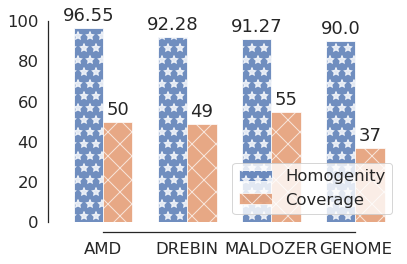

In [612]:
labels = ['AMD', 'DREBIN', 'MALDOZER', 'GENOME']
men_means = [96.55, 92.28, 91.27, 90.00]
women_means = [50, 49, 55, 37]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
#patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
rects1 = ax.bar(x - width/2, men_means, width, label='Homogenity', hatch="*", alpha=0.8)
rects2 = ax.bar(x + width/2, women_means, width, label='Coverage', hatch="x", alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

sns.despine(offset=10, trim=True);
plt.xticks(rotation=0)

fig.tight_layout()
#plt.grid(True)

plt.savefig('./plots/petadroid_family_clustering.pdf', bbox_inches='tight', transparent=True)

In [106]:
print('petadroid_family_clustering')

petadroid_family_clustering


In [74]:
mamadroid_efficiency = pd.read_parquet('traces/mamadroid_efficiency.parquet')

In [77]:
mamadroid_efficiency.loc[mamadroid_efficiency.tag == 'benign', 'time'].describe()

count    7630.000000
mean        5.541067
std         5.121218
min         0.470590
25%         1.619512
50%         3.982715
75%         7.718285
max        61.986970
Name: time, dtype: float64

In [78]:
mamadroid_efficiency.loc[mamadroid_efficiency.tag == 'malware', 'time'].describe()

count    29442.000000
mean         3.080547
std          3.780154
min          0.425270
25%          0.849647
50%          1.617126
75%          3.429858
max         35.771906
Name: time, dtype: float64

In [107]:
mamadroid_efficiency.time.describe()

count    37072.000000
mean         3.586961
std          4.211344
min          0.425270
25%          0.940418
50%          1.896338
75%          4.223997
max         61.986970
Name: time, dtype: float64

labels = ['Bengin', 'Malware']
means = [5.54, 3.08]
stds =  [5.12, 3.78]

labels = ['Bengin', 'Malware', 'All']
means = [5.54, 3.08, 3.58]
stds =  [5.12, 3.78]

In [607]:
sns.set(style="white", color_codes=True, font_scale=1.7)

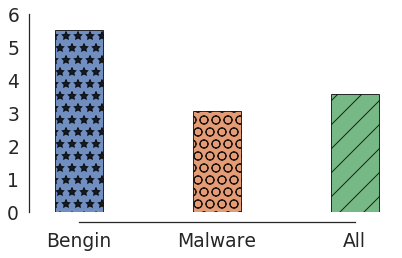

In [608]:
labels = ['Bengin', 'Malware', 'All']
means = [5.54, 3.08, 3.58]
stds =  [5.12, 3.78]

x = np.arange(len(labels))  # the label locations
#width = 0.35  # the width of the bars

fig, ax = plt.subplots()
#patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
rects1 = ax.bar(x[0], means[0], width, label='Homogenity', hatch="*", edgecolor='black', align='center', alpha=0.8, ecolor='black')
rects1 = ax.bar(x[1], means[1], width, label='Homogenity', hatch="O", edgecolor='black', align='center', alpha=0.8, ecolor='black')
rects1 = ax.bar(x[2], means[2], width, label='Homogenity', hatch="/", edgecolor='black', align='center', alpha=0.8, ecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yticks(range(0, 7))

sns.despine(offset=10, trim=True);
fig.tight_layout()

plt.savefig('./plots/petadroid_efficiency_performance.pdf', bbox_inches='tight', transparent=True)

In [ ]:
sns.set(font_scale=1.5, style='white')
sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

viper_attribution_df = pd.read_msgpack('01_bow/viper_attribution_results_df.msg')

viper_attribution_df['score'] = viper_attribution_df.f1_score.apply(int)

hashing_scores = viper_attribution_df.loc[viper_attribution_df.preprocessing_type == 'hashing'].pivot('classifier_name', 'split_line', 'score')
fig, ax = plt.subplots(figsize=(9, 6))
sns_plot = sns.heatmap(hashing_scores, annot=True, fmt="d", cbar=False, linewidths=.9, ax=ax)
sns_plot.set(ylabel='Model, F1-Score(%)', xlabel='Training Set #Samples ')
sns_plot.yaxis.set_ticklabels(classifier_lst);
sns_plot.set_axisbelow(True)
plt.grid(True)
sns_plot.figure.savefig('./plots/maldy_viper_trainsize_hashing_performance.pdf', bbox_inches='tight', transparent=True)

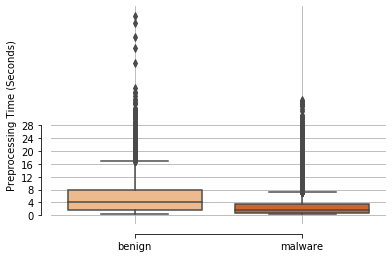

In [74]:
sns_plot = sns.boxplot(x='tag', y='time', data=mamadroid_efficiency, palette='Oranges')
sns_plot.set(xlabel='', ylabel='Preprocessing Time (Seconds)')
sns_plot.yaxis.set_ticks(range(0, 30, 4))
sns.despine(offset=10, trim=True);
plt.xticks(rotation=0)
sns_plot.set_axisbelow(True)
plt.grid(True)
sns_plot.figure.savefig('./plots/petadroid_efficiency_performance.pdf', bbox_inches='tight', transparent=True)

In [42]:
pragaurd.obfustype.value_counts()

CLASS_ENCRYPTION_APK                                         1486
STRING_ENCRYPTION_APK                                        1486
TRIVIAL_APK                                                  1485
TRIVIAL+STRING_ENCRYPTION+REFLECTION+CLASS_ENCRYPTION_APK    1483
REFLECTION_APK                                               1471
TRIVIAL+STRING_ENCRYPT_APK                                   1462
TRIVIAL+STRING_ENCRYTPION+REFLECTION_APK                     1461
Name: obfustype, dtype: int64

In [3]:
androzoo_df = pd.read_parquet('dataset/androzoo_meta.parquet')

In [9]:
androzoo_df.label.value_counts()

0    7345058
1    2072933
Name: label, dtype: int64

In [ ]:
sns.set(font_scale=1.5, style='white')
sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

viper_attribution_df = pd.read_msgpack('01_bow/viper_attribution_results_df.msg')

viper_attribution_df['score'] = viper_attribution_df.f1_score.apply(int)

hashing_scores = viper_attribution_df.loc[viper_attribution_df.preprocessing_type == 'hashing'].pivot('classifier_name', 'split_line', 'score')
fig, ax = plt.subplots(figsize=(9, 6))
sns_plot = sns.heatmap(hashing_scores, annot=True, fmt="d", cbar=False, linewidths=.9, ax=ax)
sns_plot.set(ylabel='Model, F1-Score(%)', xlabel='Training Set #Samples ')
sns_plot.yaxis.set_ticklabels(classifier_lst);
sns_plot.set_axisbelow(True)
plt.grid(True)
sns_plot.figure.savefig('./plots/maldy_viper_trainsize_hashing_performance.pdf', bbox_inches='tight', transparent=True)

In [7]:
androzoo_df.dtypes

sha256                  object
sha1                    object
md5                     object
dex_date                object
apk_size                 int64
pkg_name                object
vercode                float64
vt_detection           float64
vt_scan_date            object
dex_size                 int64
markets                 object
label                    int64
scan_date       datetime64[ns]
dtype: object

In [617]:
androzoo_df['scan_date'] = pd.to_datetime(androzoo_df.vt_scan_date)

In [621]:
androzoo_df['label'] = (androzoo_df.vt_detection > 0).apply(int)

In [622]:
androzoo_df.index = androzoo_df['scan_date']

In [623]:
malzoo_df = androzoo_df.loc[androzoo_df.label == 1]

In [624]:
benzoo_df = androzoo_df.loc[androzoo_df.label == 0]

In [625]:
sampler = androzoo_df.sha256.resample('3M')

In [626]:
malsampler = malzoo_df.sha256.resample('3M')

In [627]:
bensampler = benzoo_df.sha256.resample('3M')

In [632]:
sns.set(style="whitegrid", color_codes=True, font_scale=1.1)

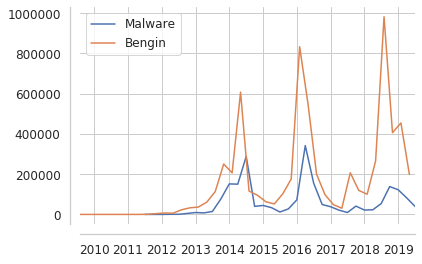

In [655]:
#fig = sampler.count().plot()
mfig = malsampler.count().plot()
bfig = bensampler.count().plot()
bfig.set_xlabel('')
#bfig.set_yticklabels([round(x, 2) for x in np.linspace(0, 1, num=len(bfig.get_yticklabels()))])
sns.despine(offset=10, trim=False);
plt.xticks(rotation=0)

plt.grid(True)
plt.legend(('Malware', 'Bengin'))
plt.savefig('./plots/androzoo_distribution_overtime.pdf', bbox_inches='tight', transparent=True)

In [ ]:
bfig.set_xlabel('')

In [652]:
bfig.set_xticklabels([round(x, 2) for x in np.linspace(0, 1, num=len(bfig.get_yticklabels()))])

[Text(480, 0, '0.0'),
 Text(492, 0, '0.14'),
 Text(504, 0, '0.29'),
 Text(516, 0, '0.43'),
 Text(528, 0, '0.57'),
 Text(540, 0, '0.71'),
 Text(552, 0, '0.86'),
 Text(564, 0, '1.0')]

In [640]:
range(0., 1., len(bfig.get_yticklabels())

8

In [643]:
range(0., 1., 4)

TypeError: 'float' object cannot be interpreted as an integer

In [651]:
[round(x, 2) for x in np.linspace(0, 1, num=len(bfig.get_yticklabels()))]

[0.0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]

In [553]:
def evalDataset(result_df, mask, tag, probaUpperBorn = 0.9,  probaLowerBorn = 0.1):
    results   = np.vstack(result_df.Proba.values)

    truth         = result_df.Truth.iloc[0][mask]
    paths         = result_df.Path.iloc[0][mask]
    result_mean   = results.mean(axis=0)[mask]
    predicted     = (result_mean > 0.5).astype('int')
    f1score       = f1_score(truth, predicted)
    recall        = recall_score(truth, predicted)
    precision     = precision_score(truth, predicted)
    
    vtruth        = truth[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vpaths        = paths[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vresult_prob  = result_mean[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vpredicted    = (vresult_prob > 0.5).astype('int')
    vcoverage     = (len(vtruth)/len(truth))
    vextendSize   = len(vtruth)
    vf1score      = f1_score(vtruth, vpredicted)
    vrecall       = recall_score(vtruth, vpredicted)
    vprecision    = precision_score(vtruth, vpredicted)
    
    message  = f'{tag:4d} '
    message += f'f1score={f1score*100:2.4f}, recall={recall*100:2.4f}, precision={precision*100:2.4f}, '
    message += f'vf1score={vf1score*100:2.4f}, vrecall={vrecall*100:2.4f}, vprecision={vprecision*100:2.4f}, vcoverage={vcoverage*100:2.4f}, '
    #message += f'ecoverage={ecoverage*100:2.4f}, ef1score={ef1score*100:2.4f}, erestSize={erestSize}'

    print(message)

In [554]:
dataset_metaList = glob.glob('traces/detectionWS04/*.pickle')

dataset_metaList = [ 'traces/detectionWS04/2013.pickle',
                     'traces/detectionWS04/2014.pickle',
                     'traces/detectionWS04/2015.pickle',
                     'traces/detectionWS04/2016.pickle',
                     'traces/detectionWS04/2017.pickle',
                     'traces/detectionWS04/2018.pickle',
                     'traces/detectionWS04/2019.pickle']
timedf = pd.read_parquet('dataset/timedf.parquet')
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [555]:
ensembleSize = 6

In [556]:
for dbPath in dataset_metaList:
    print(dbPath)
    df = pd.read_pickle(dbPath)
    for year in years:

        models_df = df.models.iloc[0]
        result_df = df.evalResuls.iloc[0]
        models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
        selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
        current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
        yearHashes = timedf.loc[timedf.year == year, 'sha256'].to_list()
        masklst = np.array([True if x.split('/')[-1] in yearHashes else False for x in result_df.Path.iloc[0].tolist()])
        if masklst.sum() != 0:
            evalDataset(current_result_df, masklst, year)

traces/detectionWS04/2013.pickle
2014 f1score=94.9535, recall=90.8800, precision=99.4093, vf1score=98.1737, vrecall=96.5125, vprecision=99.8930, vcoverage=87.2800, 
2015 f1score=91.4027, recall=84.8400, precision=99.0659, vf1score=96.1052, vrecall=92.5721, vprecision=99.9187, vcoverage=87.8500, 
2016 f1score=77.5236, recall=63.3600, precision=99.8424, vf1score=83.0170, vrecall=70.9650, vprecision=100.0000, vcoverage=84.5100, 
2017 f1score=71.8934, recall=56.1200, precision=100.0000, vf1score=70.6061, vrecall=54.5668, vprecision=100.0000, vcoverage=83.9800, 
2018 f1score=56.3631, recall=39.2400, precision=100.0000, vf1score=54.8221, vrecall=37.7620, vprecision=100.0000, vcoverage=77.9000, 
2019 f1score=44.4790, recall=28.6000, precision=100.0000, vf1score=55.5974, vrecall=38.5017, vprecision=100.0000, vcoverage=70.9900, 
traces/detectionWS04/2014.pickle
2013 f1score=96.5668, recall=97.3200, precision=95.8251, vf1score=98.6255, vrecall=98.6047, vprecision=98.6464, vcoverage=91.5000, 
201

In [278]:
for dbPath in dataset_metaList:
    print(dbPath)
    df = pd.read_pickle(dbPath)
    for year in years:

        models_df = df.models.iloc[0]
        result_df = df.evalResuls.iloc[0]
        models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
        selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
        current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
        yearHashes = timedf.loc[timedf.year == year, 'sha256'].to_list()
        masklst = np.array([True if x.split('/')[-1] in yearHashes else False for x in result_df.Path.iloc[0].tolist()])
        if masklst.sum() != 0:
            evalDataset(current_result_df, masklst, year)

traces/detectionWS04/2013.pickle
2014 f1score=94.9535, recall=90.8800, precision=99.4093, vf1score=98.1737, vrecall=96.5125, vprecision=99.8930, vcoverage=87.2800, 
2015 f1score=91.4027, recall=84.8400, precision=99.0659, vf1score=96.1052, vrecall=92.5721, vprecision=99.9187, vcoverage=87.8500, 
2016 f1score=77.5236, recall=63.3600, precision=99.8424, vf1score=83.0170, vrecall=70.9650, vprecision=100.0000, vcoverage=84.5100, 
2017 f1score=71.8934, recall=56.1200, precision=100.0000, vf1score=70.6061, vrecall=54.5668, vprecision=100.0000, vcoverage=83.9800, 
2018 f1score=56.3631, recall=39.2400, precision=100.0000, vf1score=54.8221, vrecall=37.7620, vprecision=100.0000, vcoverage=77.9000, 
2019 f1score=44.4790, recall=28.6000, precision=100.0000, vf1score=55.5974, vrecall=38.5017, vprecision=100.0000, vcoverage=70.9900, 
traces/detectionWS04/2014.pickle
2013 f1score=96.5668, recall=97.3200, precision=95.8251, vf1score=98.6255, vrecall=98.6047, vprecision=98.6464, vcoverage=91.5000, 
201

In [296]:
markersizeParam = 10
linewidthParam  = 5
alphaParam=0.8

yeas = [2014, 2015, 2016, 2017, 2018, 2019,]
gf1  = [94.95, 91.40, 77.52, 71.89, 56.36, 44.47,]
cf1  = [98.17, 96.10, 93.01, 70.60, 54.82, 55.59,]

In [595]:
sns.set(style="white", color_codes=True, font_scale=1.7)

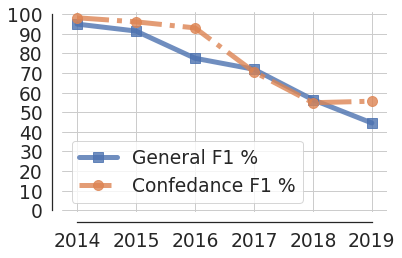

In [599]:
training_year = 2013
yeas = [2014, 2015, 2016, 2017, 2018, 2019,]
gf1  = [94.95, 91.40, 77.52, 71.89, 56.36, 44.47,]
cf1  = [98.17, 96.10, 93.01, 70.60, 54.82, 55.59,]

ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))

ax.set_yticks(np.arange(0, 101, 10)) 
ax.set_xticks(yeas) 

sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

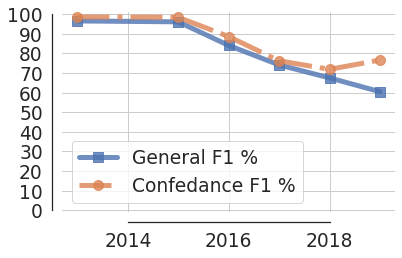

In [600]:
training_year = 2014
yeas = [2013, 2015, 2016, 2017, 2018, 2019,]
gf1  = [96.56, 96.10, 84.04, 74.10, 67.47, 60.44,]
cf1  = [98.62, 98.41, 88.58, 76.21, 71.87, 76.59,]

ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

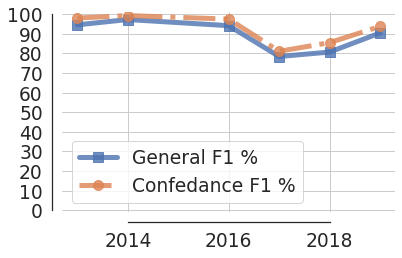

In [601]:
training_year = 2015
yeas = [2013, 2014, 2016, 2017, 2018, 2019,]
gf1  = [94.57, 97.27, 94.14, 78.40, 80.68, 90.42,]
cf1  = [98.03, 99.29, 97.49, 81.07, 85.49, 93.76,]

ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

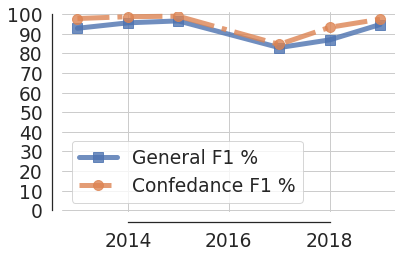

In [602]:
training_year = 2016
yeas = [2013, 2014, 2015, 2017, 2018, 2019,]
gf1  = [92.82, 95.59, 96.58, 82.95, 86.88, 94.71,]
cf1  = [97.79, 98.72, 98.99, 84.57, 93.30, 97.45,]

ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

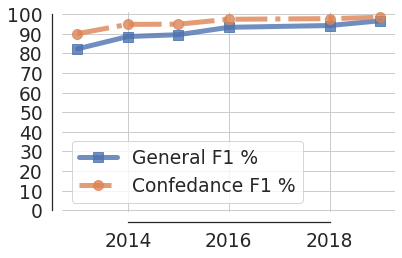

In [603]:
training_year = 2017
yeas = [2013, 2014, 2015, 2016, 2018, 2019,]
gf1  = [82.30, 88.60, 89.53, 93.30, 94.21, 96.63,]
cf1  = [90.07, 94.81, 94.90, 97.41, 97.74, 98.41,]


ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

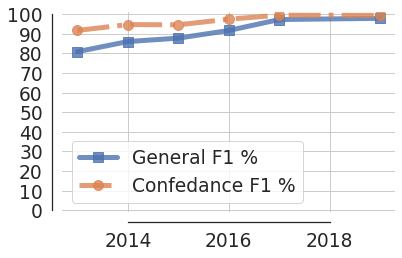

In [604]:
training_year = 2018
yeas = [2013, 2014, 2015, 2016, 2017, 2019,]
gf1  = [80.88, 86.04, 87.78, 91.68, 97.27, 97.89,]
cf1  = [91.72, 94.69, 94.58, 97.46, 99.48, 99.40,]


ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

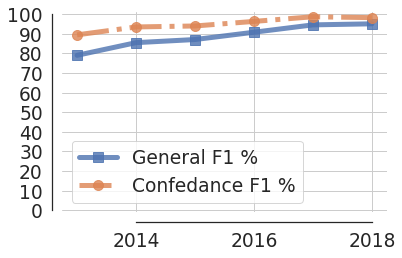

In [605]:
training_year = 2019
yeas = [2013, 2014, 2015, 2016, 2017, 2018,]
gf1  = [79.01, 85.48, 87.07, 90.80, 94.55, 95.09,]
cf1  = [89.46, 93.49, 93.99, 96.32, 98.69, 98.24,]


ax = plt.subplot()
ax.plot(yeas, gf1, '-s',  alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='General F1 %')
ax.plot(yeas, cf1, '-.o', alpha=alphaParam, linewidth=linewidthParam, markersize=markersizeParam, label='Confedance F1 %')

ax.set_ylim((-1.1, 101))
ax.set_yticks(np.arange(0, 101, 10)) 
sns.despine(offset=10, trim=True);

#plt.xticks(range(len(yeas)), list([str(yr) for yr in yeas]))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./plots/detection_overtime_' + str(training_year) + '.pdf', bbox_inches='tight', transparent=True)

In [284]:
yeas

[2014, 2015, 2016, 2017, 2018, 2019]

In [317]:
dataset_metaList = glob.glob('traces/comparativeWS01/*.pickle')


In [318]:
dataset_metaList

['traces/comparativeWS01/2014_new.pickle',
 'traces/comparativeWS01/2015_new.pickle',
 'traces/comparativeWS01/2016_new.pickle',
 'traces/comparativeWS01/2014_old.pickle',
 'traces/comparativeWS01/2013_old.pickle',
 'traces/comparativeWS01/drebin_old.pickle']

In [564]:
def evalDataset(result_df, mask, tag, probaUpperBorn = 0.9,  probaLowerBorn = 0.1):
    results   = np.vstack(result_df.Proba.values)

    truth         = result_df.Truth.iloc[0][mask]
    paths         = result_df.Path.iloc[0][mask]
    result_mean   = results.mean(axis=0)[mask]
    predicted     = (result_mean > 0.5).astype('int')
    f1score       = f1_score(truth, predicted)
    recall        = recall_score(truth, predicted)
    precision     = precision_score(truth, predicted)
    
    vtruth        = truth[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vpaths        = paths[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vresult_prob  = result_mean[(result_mean >= probaUpperBorn) | (result_mean <= probaLowerBorn)]
    vpredicted    = (vresult_prob > 0.5).astype('int')
    vcoverage     = (len(vtruth)/len(truth))
    vextendSize   = len(vtruth)
    vf1score      = f1_score(vtruth, vpredicted)
    vrecall       = recall_score(vtruth, vpredicted)
    vprecision    = precision_score(vtruth, vpredicted)
    
    message  = f'{tag} '
    message += f'f1score={f1score*100:2.4f}, recall={recall*100:2.4f}, precision={precision*100:2.4f}, '
    message += f'vf1score={vf1score*100:2.4f}, vrecall={vrecall*100:2.4f}, vprecision={vprecision*100:2.4f}, vcoverage={vcoverage*100:2.4f}, '
    #message += f'ecoverage={ecoverage*100:2.4f}, ef1score={ef1score*100:2.4f}, erestSize={erestSize}'

    print(message)

In [497]:
dataset_metaList = glob.glob('traces/comparativeWS01/*.pickle')
dataset_metaList

['traces/comparativeWS01/drebin_old.pickle']

In [498]:
dataset_metaList =['traces/comparativeWS01/drebin_old.pickle',
                   'traces/comparativeWS01/2013_old.pickle',
                   'traces/comparativeWS01/2014_old.pickle',
                   'traces/comparativeWS01/2014_new.pickle',
                   'traces/comparativeWS01/2015_new.pickle',
                   'traces/comparativeWS01/2016_new.pickle',
                     ]

#timedf = pd.read_parquet('dataset/timedf.parquet')
#years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [338]:
mamadroid_meta_df = pd.read_parquet('dataset/mamadroid_meta.parquet')
mamadroid_meta_df = mamadroid_meta_df[['sha256', 'year', 'tag']]

drebin_df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_meta.msg')
drebin_df = drebin_df[['sha256']]
drebin_df['tag'] = 'malware'
drebin_df['year'] = 'drebin'
drebin_df.reset_index(drop=True, inplace=True)

mamadroid_df = pd.concat([mamadroid_meta_df, drebin_df], sort=False)
mamadroid_df.drop_duplicates(subset='sha256', inplace=True)

doneList = [item.split('/')[-1] for item in glob.glob('/ws/mnt/local/data/output/mamadroid/*')]
mamadroid_df = mamadroid_df.loc[mamadroid_df.sha256.isin(doneList)]

mamadroid_df['label'] = (mamadroid_df.tag == 'malware').apply(int)
mamadroid_df['filePath'] = '/ws/mnt/local/data/output/mamadroid/' + mamadroid_df.sha256
print(len(mamadroid_df))

/opt/conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


41712


In [339]:
#androzoo_df = pd.read_parquet('dataset/androzoo_meta.parquet')
df = androzoo_df.loc[androzoo_df.sha256.isin(mamadroid_df.loc[mamadroid_df.label == 0, 'sha256'])]
df.dropna(subset=['vt_detection'], inplace=True)
df = df.loc[df.vt_detection > 0]
mamadroid_df = mamadroid_df.loc[~mamadroid_df.sha256.isin(df.sha256)]
print(len(mamadroid_df))

df = androzoo_df.loc[androzoo_df.sha256.isin(mamadroid_df.loc[mamadroid_df.label == 1, 'sha256'])]
df.dropna(subset=['vt_detection'], inplace=True)
df = df.loc[df.vt_detection < 4]
mamadroid_df = mamadroid_df.loc[~mamadroid_df.sha256.isin(df.sha256)]
print(len(mamadroid_df))

mamadroid_df.groupby(['year', 'label']).count()

/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


40706
37758


/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,,sha256,tag,filePath
year,label,,,
2013,1,6928,6928,6928
2014,1,13654,13654,13654
2015,1,3732,3732,3732
2016,1,2184,2184,2184
drebin,1,4636,4636,4636
new,0,1638,1638,1638
old,0,4986,4986,4986


In [ ]:
for btag in benignTags:
    for mtag in ben

In [ ]:
dbPath = dataset_metaList[0]

In [502]:
ensembleSize = 6
dbPath       = dataset_metaList[0]
tag          = tags[-1]

['2016', 'new']

In [549]:
tags = [
        ['drebin', 'old'],
        ['2013',   'old'],
        ['2014',   'old'],
        ['2015',   'old'],
        ['2016',   'old'],
        ['drebin', 'new'],
        ['2013',   'new'],
        ['2014',   'new'],
        ['2015',   'new'],
        ['2016',   'new'],
       ]

In [548]:
dbPath = 'traces/comparativeWS01/drebin_old.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=99.4282, recall=99.3960, precision=99.4604, vf1score=99.8563, vrecall=99.8673, vprecision=99.8452, vcoverage=97.4434, 
2013_old f1score=98.6221, recall=97.6328, precision=99.6318, vf1score=99.6964, vrecall=99.5225, vprecision=99.8710, vcoverage=86.4445, 
2014_old f1score=73.2487, recall=57.8951, precision=99.6847, vf1score=83.1139, vrecall=71.1773, vprecision=99.8607, vcoverage=63.8627, 
2015_old f1score=40.9735, recall=25.9378, precision=97.4824, vf1score=39.1619, vrecall=24.4297, vprecision=98.6564, vcoverage=79.8119, 
2016_old f1score=44.4366, recall=28.8919, precision=96.1890, vf1score=35.7469, vrecall=21.8850, vprecision=97.5089, vcoverage=85.1604, 
drebin_new f1score=99.5248, recall=99.3960, precision=99.6540, vf1score=99.9226, vrecall=99.8673, vprecision=99.9779, vcoverage=97.3063, 
2013_new f1score=98.6869, recall=97.6328, precision=99.7640, vf1score=99.7515, vrecall=99.5225, vprecision=99.9815, vcoverage=82.0453, 
2014_new f1score=73.2793, recall=57.8951, pr

In [550]:
dbPath = 'traces/comparativeWS01/2013_old.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=97.8285, recall=96.2036, precision=99.5091, vf1score=99.3330, vrecall=98.8855, vprecision=99.7846, vcoverage=94.0865, 
2013_old f1score=99.6100, recall=99.5381, precision=99.6820, vf1score=99.8309, vrecall=99.7942, vprecision=99.8676, vcoverage=97.7002, 
2014_old f1score=85.3886, recall=74.6228, precision=99.7845, vf1score=92.0168, vrecall=85.3004, vprecision=99.8812, vcoverage=73.5354, 
2015_old f1score=59.3217, recall=42.4169, precision=98.6293, vf1score=67.1968, vrecall=50.8730, vprecision=98.9461, vcoverage=74.5240, 
2016_old f1score=56.5670, recall=39.8352, precision=97.5336, vf1score=61.6541, vrecall=44.9315, vprecision=98.2036, vcoverage=82.7197, 
drebin_new f1score=97.9681, recall=96.2036, precision=99.7986, vf1score=99.3804, vrecall=98.8855, vprecision=99.8802, vcoverage=92.2219, 
2013_new f1score=99.7036, recall=99.5381, precision=99.8697, vf1score=99.8603, vrecall=99.7942, vprecision=99.9264, vcoverage=97.7469, 
2014_new f1score=85.4352, recall=74.6228, pr

In [565]:
dbPath = 'traces/comparativeWS01/2014_old.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=95.7883, recall=93.7015, precision=97.9702, vf1score=98.6101, vrecall=97.6275, vprecision=99.6127, vcoverage=89.4824, 
2013_old f1score=98.6424, recall=98.5855, precision=98.6994, vf1score=99.5829, vrecall=99.4052, vprecision=99.7612, vcoverage=93.3356, 
2014_old f1score=99.4035, recall=99.4654, precision=99.3417, vf1score=99.8490, vrecall=99.8189, vprecision=99.8792, vcoverage=94.6674, 
2015_old f1score=91.4205, recall=86.2272, precision=97.2793, vf1score=96.3296, vrecall=93.4593, vprecision=99.3818, vcoverage=81.9798, 
2016_old f1score=88.9648, recall=83.4249, precision=95.2929, vf1score=90.8848, vrecall=84.1162, vprecision=98.8381, vcoverage=83.8633, 
drebin_new f1score=96.2020, recall=93.7015, precision=98.8396, vf1score=98.6811, vrecall=97.6275, vprecision=99.7576, vcoverage=87.0577, 
2013_new f1score=98.9210, recall=98.5855, precision=99.2588, vf1score=99.6274, vrecall=99.4052, vprecision=99.8506, vcoverage=93.0656, 
2014_new f1score=99.5456, recall=99.4654, pr

In [582]:
dbPath = 'traces/comparativeWS01/2014_new.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=82.6317, recall=99.2882, precision=70.7610, vf1score=91.4972, vrecall=99.9551, vprecision=84.3590, vcoverage=74.8181, 
2013_old f1score=87.8374, recall=99.8124, precision=78.4280, vf1score=94.3269, vrecall=100.0000, vprecision=89.2630, vcoverage=80.6530, 
2014_old f1score=93.4448, recall=99.9121, precision=87.7638, vf1score=97.0307, vrecall=100.0000, vprecision=94.2326, vcoverage=87.1137, 
2015_old f1score=71.9691, recall=84.8607, precision=62.4778, vf1score=82.0829, vrecall=88.7704, vprecision=76.3324, vcoverage=65.8752, 
2016_old f1score=54.8748, recall=70.7418, precision=44.8216, vf1score=68.4123, vrecall=79.5003, vprecision=60.0387, vcoverage=60.0139, 
drebin_new f1score=99.2775, recall=99.2882, precision=99.2668, vf1score=99.8319, vrecall=99.9551, vprecision=99.7090, vcoverage=95.2662, 
2013_new f1score=99.6613, recall=99.8124, precision=99.5107, vf1score=99.9054, vrecall=100.0000, vprecision=99.8110, vcoverage=97.9103, 
2014_new f1score=99.8317, recall=99.9121,

In [583]:
dbPath = 'traces/comparativeWS01/2015_new.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=81.8760, recall=90.1855, precision=74.9686, vf1score=93.1892, vrecall=96.8194, vprecision=89.8213, vcoverage=54.9574, 
2013_old f1score=88.8280, recall=96.0017, precision=82.6519, vf1score=95.7483, vrecall=98.2694, vprecision=93.3534, vcoverage=60.7269, 
2014_old f1score=92.4578, recall=94.7634, precision=90.2616, vf1score=96.8322, vrecall=96.8404, vprecision=96.8241, vcoverage=73.4871, 
2015_old f1score=83.6661, recall=98.8210, precision=72.5413, vf1score=94.8271, vrecall=99.8853, vprecision=90.2565, vcoverage=61.3443, 
2016_old f1score=72.0972, recall=92.3993, precision=59.1095, vf1score=88.5854, vrecall=96.2486, vprecision=82.0525, vcoverage=50.8647, 
drebin_new f1score=94.5286, recall=90.1855, precision=99.3112, vf1score=98.2965, vrecall=96.8194, vprecision=99.8195, vcoverage=76.3787, 
2013_new f1score=97.7513, recall=96.0017, precision=99.5659, vf1score=99.0714, vrecall=98.2694, vprecision=99.8865, vcoverage=78.6715, 
2014_new f1score=97.2053, recall=94.7634, pr

In [584]:
dbPath = 'traces/comparativeWS01/2016_new.pickle'
for tag in tags:
    current_tag = "_".join(tag)
    tag_df      = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]
    taglist     = tag_df.sha256.values

    df        = pd.read_pickle(dbPath)
    models_df = df.models.iloc[0]
    result_df = df.evalResuls.iloc[0]

    filePathList = result_df.Path.iloc[0]
    fileHashList = [x.split('/')[-1] for x in filePathList]
    masklist     = [True if x in taglist else False for x in fileHashList]

    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()
    current_result_df = result_df.loc[result_df.name.isin(selectedModelPaths)]
    evalDataset(current_result_df, masklist, current_tag)

drebin_old f1score=84.2311, recall=83.6497, precision=84.8206, vf1score=94.6575, vrecall=95.3432, vprecision=93.9816, vcoverage=58.7820, 
2013_old f1score=91.4477, recall=92.6819, precision=90.2460, vf1score=95.7275, vrecall=96.5357, vprecision=94.9327, vcoverage=51.9725, 
2014_old f1score=93.8247, recall=92.8592, precision=94.8104, vf1score=97.1965, vrecall=96.0688, vprecision=98.3510, vcoverage=73.7446, 
2015_old f1score=86.9909, recall=91.2915, precision=83.0773, vf1score=96.0539, vrecall=97.8887, vprecision=94.2866, vcoverage=65.8523, 
2016_old f1score=85.0180, recall=97.4359, precision=75.4075, vf1score=95.3960, vrecall=99.5351, vprecision=91.5875, vcoverage=65.4533, 
drebin_new f1score=90.9368, recall=83.6497, precision=99.6147, vf1score=97.5989, vrecall=95.3432, vprecision=99.9638, vcoverage=68.8715, 
2013_new f1score=96.0940, recall=92.6819, precision=99.7669, vf1score=98.2227, vrecall=96.5357, vprecision=99.9699, vcoverage=56.7009, 
2014_new f1score=96.2426, recall=92.8592, pr

In [591]:
g = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_obfus_meta.msg')

/opt/conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [593]:
g = pd.read_parquet('/ws/mnt/local/data/output/obfus/praguard_meta.parquet')

In [594]:
len()

29535

In [588]:
len(g.genome.value_counts())

49

In [570]:
androzoo_df.head().vt_scan_date.apply(lambda x: x.split('-')[0])

0    2016
1    2016
2    2017
3    2019
4    2014
Name: vt_scan_date, dtype: object

In [580]:
androzoo_df.vt_scan_date.str.startswith('2013-01').sum()

24193

In [572]:
androzoo_df['year'] = androzoo_df.vt_scan_date.apply(lambda x: str(x).split('-')[0])

In [574]:
s = androzoo_df.year.value_counts()

In [ ]:
5.5 million

In [575]:
s.sort_index()

2009          1
2010         15
2011       4161
2012      60106
2013     618674
2014    1605887
2015     501565
2016    2270393
2017     545997
2018    2091371
2019     819844
None     899977
Name: year, dtype: int64

In [557]:
mdataset_df = pd.read_parquet('dataset/mdataset.parquet')
print(len(mdataset_df))

malware_overtime = mdataset_df.resample('3M', on='vt_scan_date', convention='start')

malware_overtime.count()

962411


,sha256,sha1,md5,dex_date,apk_size,pkg_name,vercode,vt_detection,vt_scan_date,dex_size,markets,label,filePath
vt_scan_date,,,,,,,,,,,,,
2013-01-31,2960,2960,2960,2960,2960,2960,2948,2960,2960,2960,2960,2960,2960
2013-04-30,5539,5539,5539,5539,5539,5539,5532,5539,5539,5539,5539,5539,5539
2013-07-31,9581,9581,9581,9581,9581,9581,9560,9581,9581,9581,9581,9581,9581
2013-10-31,22793,22793,22793,22790,22793,22793,22736,22793,22793,22793,22793,22793,22793
2014-01-31,50077,50075,50075,50073,50077,50077,49967,50077,50077,50077,50077,50077,50077
2014-04-30,38791,38788,38788,38790,38791,38791,38676,38791,38791,38791,38791,38791,38791
2014-07-31,103358,103332,103332,103356,103358,103358,103332,103358,103358,103358,103358,103358,103358
2014-10-31,17485,17482,17482,17485,17485,17485,17484,17485,17485,17485,17485,17485,17485
2015-01-31,19570,19570,19570,19570,19570,19570,19570,19570,19570,19570,19570,19570,19570


In [566]:
malware_overtime = mdataset_df.resample('12M', on='vt_scan_date', convention='start')

malware_overtime.count()

,sha256,sha1,md5,dex_date,apk_size,pkg_name,vercode,vt_detection,vt_scan_date,dex_size,markets,label,filePath
vt_scan_date,,,,,,,,,,,,,
2013-01-31,2960,2960,2960,2960,2960,2960,2948,2960,2960,2960,2960,2960,2960
2014-01-31,87990,87988,87988,87983,87990,87990,87795,87990,87990,87990,87990,87990,87990
2015-01-31,179204,179172,179172,179201,179204,179204,179062,179204,179204,179204,179204,179204,179204
2016-01-31,69153,69153,69153,69153,69153,69153,69153,69153,69153,69153,69153,69153,69153
2017-01-31,264527,264527,264527,264527,264527,264527,264527,264527,264527,264527,264527,264527,264527
2018-01-31,55215,55215,55215,55215,55215,55215,55215,55215,55215,55215,55215,55215,55215
2019-01-31,214102,214102,214102,214102,214102,214102,214102,214102,214102,214102,214102,214102,214102
2020-01-31,89260,89260,89260,89260,89260,89260,89260,89260,89260,89260,89260,89260,89260


In [562]:
[dt.isoformat() for dt in malware_overtime.count().index]

['2013-01-31T00:00:00',
 '2013-04-30T00:00:00',
 '2013-07-31T00:00:00',
 '2013-10-31T00:00:00',
 '2014-01-31T00:00:00',
 '2014-04-30T00:00:00',
 '2014-07-31T00:00:00',
 '2014-10-31T00:00:00',
 '2015-01-31T00:00:00',
 '2015-04-30T00:00:00',
 '2015-07-31T00:00:00',
 '2015-10-31T00:00:00',
 '2016-01-31T00:00:00',
 '2016-04-30T00:00:00',
 '2016-07-31T00:00:00',
 '2016-10-31T00:00:00',
 '2017-01-31T00:00:00',
 '2017-04-30T00:00:00',
 '2017-07-31T00:00:00',
 '2017-10-31T00:00:00',
 '2018-01-31T00:00:00',
 '2018-04-30T00:00:00',
 '2018-07-31T00:00:00',
 '2018-10-31T00:00:00',
 '2019-01-31T00:00:00',
 '2019-04-30T00:00:00',
 '2019-07-31T00:00:00']

In [560]:
s.isoformat()

'2013-01-31T00:00:00'

In [38]:
print('androzoo_distribution_overtime')

androzoo_distribution_overtime


In [12]:
sampler1M = androzoo_df.sha256.resample('1M')

sampler6M = androzoo_df.sha256.resample('6M')

In [37]:
androzoo_df.head()

,sha256,sha1,md5,dex_date,apk_size,pkg_name,vercode,vt_detection,vt_scan_date,dex_size,markets
0,0000003b455a6c7af837ef90f2eaffd856e3b5cf49f5e2...,9c14d537a7adb4cfc43d291352f73e05e0ccdd4a,3edfc78ab53521942798ad551027d04f,2016-04-05 17:58:46,10386469,com.zte.bamachaye,121.0,0.0,2016-06-15 15:26:44,4765888,anzhi
1,0000014a634db98f85038b833a8dfc50d5fb13a464e0b2...,c3ebec52c9388bf67479ff1385a56c59b3e39e81,0a146750fb447cf3859c9cb659ab04f1,2014-08-20 13:58:10,3537486,com.tanersenel.onlinetvizle,16.0,0.0,2016-11-20 10:26:31,3170096,PlayDrone
2,000002b63fad4b030787f6de4081dc1e12325026eb7dda...,dd723b32edd9f70aadbd66846621967157df9bd4,985e601c17f0a9346590ae92a5ad664e,1980-01-01 00:00:00,4300370,com.deperu.sitiosarequipa,10000.0,0.0,2017-12-03 06:50:28,4211104,play.google.com
3,000003d3981dc548a772a30d688f424cfb88561a63a2dd...,6ae9f138f7e0c63e5d58cc7e82fb05a50f041637,f4789023733e41ee883208acbc956020,1980-01-01 00:00:00,12958838,com.safetravels.safetravelsmain,400125.0,0.0,2019-06-25 08:55:42,7813520,play.google.com
4,00000439a3ffa123c3f9bc45e5e821351b1a5c276871b3...,375d6ffd167bb5e7e2935b1b927f87d8e44a9ab4,9283c74dd8356c18bb6d94b88b8fdd9b,2011-10-25 02:30:56,1044597,bmthx.god102409paperi,6.0,1.0,2014-04-27 06:30:31,105660,appchina


In [38]:
len(androzoo_df)

9417991

In [52]:
df = androzoo_df.loc[androzoo_df.sha256.isin(mamadroid_df.loc[mamadroid_df.label == 1, 'sha256'])]
df.dropna(subset=['vt_detection'], inplace=True)
df = df.loc[df.vt_detection < 4]

/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fig, ax = 

In [3]:
mamadroid_meta_df = pd.read_parquet('dataset/mamadroid_meta.parquet')

mamadroid_meta_df = pd.read_parquet('dataset/mamadroid_meta.parquet')
mamadroid_meta_df = mamadroid_meta_df[['sha256', 'year', 'tag']]

drebin_df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_meta.msg')
drebin_df = drebin_df[['sha256']]
drebin_df['tag'] = 'malware'
drebin_df['year'] = 'drebin'
drebin_df.reset_index(drop=True, inplace=True)

mamadroid_df = pd.concat([mamadroid_meta_df, drebin_df], sort=False)
mamadroid_df.drop_duplicates(subset='sha256', inplace=True)

doneList = [item.split('/')[-1] for item in glob.glob('/ws/mnt/local/data/output/mamadroid/*')]
mamadroid_df = mamadroid_df.loc[mamadroid_df.sha256.isin(doneList)]

mamadroid_df['label'] = (mamadroid_df.tag == 'malware').apply(int)
mamadroid_df['filePath'] = '/ws/mnt/local/data/output/mamadroid/' + mamadroid_df.sha256

In [54]:
mamadroid_df.loc[mamadroid_df.sha256.isin(df.sha256)].year.value_counts()

2015      1368
2014      1075
2016       491
2013        11
drebin       3
Name: year, dtype: int64

In [44]:
mamadroid_df = mamadroid_df.loc[~mamadroid_df.sha256.isin(df.sha256)]

In [45]:
mamadroid_df.groupby(['year', 'label']).count()

,,sha256,tag,filePath
year,label,,,
2013,1,6939,6939,6939
2014,1,14729,14729,14729
2015,1,5100,5100,5100
2016,1,2675,2675,2675
drebin,1,4639,4639,4639
new,0,1759,1759,1759
old,0,5871,5871,5871


In [8]:
tags = [
        ['drebin', 'old'],
        ['2013',   'old'],
        ['2014',   'old'],
        ['2014',   'new'],
        ['2015',   'new'],
        ['2016',   'new'],
       ]

In [ ]:
for tag in tags:
    currentTag = tag[0] + '_' + tag[1]

    message  = '######## '
    message += currentTag

    with open(outputlogFilePath, 'a') as writer:
        writer.write(message + '\n')
    print(message)

    #
    dataset_df = mamadroid_df.loc[(mamadroid_df.year == tag[0]) | (mamadroid_df.year == tag[1])]

    #
    trainLoader, validLoader, testLoader = getDataloaders(dataset_df, trainPercentage=trainPercentageParam, 
                                                                      validPercentage=validPercentageParam)

    #
    models_df = trainModel(ws, f'train_{currentTag}', epochNum, trainLoader, validLoader, device)
    models_df.sort_values(by=['vloss', 'tloss'], inplace=True)
    selectedModelPaths = models_df.path.iloc[:ensembleSize].tolist()

    #
    evalresult_df = evaluate(ws, selectedModelPaths, testLoader, device)

    #
    evalDataset(ws, evalresult_df, probaUpperBorn=0.8,  probaLowerBorn=0.2)

    #
    outputPath = f'traces/{ws}/{currentTag}.pickle'
    currentResults = pd.DataFrame([(currentTag, models_df, evalresult_df)], columns=['TimeTag', 'models', 'evalResuls'])
    currentResults.to_pickle(outputPath)

    #
    message = '########'
    with open(outputlogFilePath, 'a') as writer:
        writer.write(message + '\n')
    print(message)

######## drebin_old
7356
0    4108
1    3248
Name: label, dtype: int64
1052
0    603
1    449
Name: label, dtype: int64
2102
0    1160
1     942
Name: label, dtype: int64
----------
